In [1]:
!pip install -U huggingface-hub==0.34.4


In [1]:
!pip install -U diffusers transformers gradio peft


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.12.1
    Uninstalling gradio_client-1.12.1:
      Successfully uninstalled gradio_client-1.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.44.1
    Uninstalling gradio-5.44.1:
      Successfully uninstalled gradio-5.44.1


In [2]:
!pip install -q roboflow yolov5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/

In [3]:
import json
import os
from glob import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Colab Notebooks/archive.zip"  # path of zip in Google Drive
extract_path = "/content/hit-uav"  # extract inside Colab working directory

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction Done! Files are available at:", extract_path)

✅ Extraction Done! Files are available at: /content/hit-uav


In [6]:
import json
from glob import glob
from tqdm import tqdm
from PIL import Image

In [13]:
def convert_yolo_to_coco(img_dir, label_dir, save_path, class_list):
    # COCO category IDs typically start from 1
    categories = [{"id": i + 1, "name": name, "supercategory": name} for i, name in enumerate(class_list)]
    coco_dict = {"info": {}, "images": [], "annotations": [], "categories": categories}

    ann_id = 0
    img_id = 0

    for img_path in tqdm(glob(f"{img_dir}/*.jpg")):
        file_name = os.path.basename(img_path)
        im = Image.open(img_path)
        width, height = im.size

        coco_dict["images"].append({
            "id": img_id,
            "file_name": img_path,  # absolute path helps Detectron2
            "width": width,
            "height": height
        })

        label_path = os.path.join(label_dir, file_name.replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    try:
                        cls, x, y, w, h = map(float, line.strip().split())
                        # Adjust class ID to be 1-based
                        category_id = int(cls) + 1
                        if category_id > len(class_list):
                            continue
                        x_center = x * width
                        y_center = y * height
                        box_width = w * width
                        box_height = h * height

                        x_min = float(x_center - box_width / 2)
                        y_min = float(y_center - box_height / 2)
                        bbox_width = float(box_width)
                        bbox_height = float(box_height)

                        bbox = [x_min, y_min, bbox_width, bbox_height]

                        coco_dict["annotations"].append({
                            "id": ann_id,
                            "image_id": img_id,
                            "category_id": category_id,  # Use the 1-based category ID
                            "bbox": bbox,
                            "area": float(bbox_width * bbox_height),
                            "iscrowd": 0
                        })
                        ann_id += 1
                    except ValueError as e:
                        print(f"Skipping malformed line in {label_path}: {line.strip()} - {e}")


        img_id += 1

    with open(save_path, "w") as f:
        json.dump(coco_dict, f, indent=4)

    # Add a check to ensure the generated JSON is valid
    try:
        with open(save_path, "r") as f:
            json.load(f)
        print(f"✅ COCO JSON saved and validated at {save_path}")
    except json.JSONDecodeError as e:
        print(f"❌ Error: Generated JSON file is invalid at {save_path}: {e}")


class_list = ["person", "vehicle", "others"]

convert_yolo_to_coco(
    img_dir="/content/hit-uav/hit-uav/images/train",
    label_dir="/content/hit-uav/hit-uav/labels/train",
    save_path="/content/train.json",
    class_list=class_list
)

convert_yolo_to_coco(
    img_dir="/content/hit-uav/hit-uav/images/val",
    label_dir="/content/hit-uav/hit-uav/labels/val",
    save_path="/content/val.json",
    class_list=class_list
)

print("✅ Conversion finished! JSON files are ready.")

100%|██████████| 2008/2008 [00:00<00:00, 3655.70it/s]


✅ COCO JSON saved and validated at /content/train.json


100%|██████████| 287/287 [00:00<00:00, 7119.63it/s]

✅ COCO JSON saved and validated at /content/val.json
✅ Conversion finished! JSON files are ready.


In [9]:
!pip install -q git+https://github.com/facebookresearch/detectron2.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.4 MB/s eta 0:00:00


In [18]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Remove old registration
for d in ["hit_train2", "hit_val2"]:
    if d in DatasetCatalog.list():
        DatasetCatalog.remove(d)
        MetadataCatalog.remove(d)

# Re-register with correct paths
from detectron2.data.datasets import register_coco_instances
register_coco_instances("hit_train2", {}, "/content/train.json", "/content/hit-uav/hit-uav/images/train")
register_coco_instances("hit_val2", {}, "/content/val.json", "/content/hit-uav/hit-uav/images/val")

print("✅ Re-registered datasets with correct paths")

✅ Re-registered datasets with correct paths


In [19]:
from pycocotools.coco import COCO

# path to your annotation file
train_json = "/content/train.json"

# load dataset
coco = COCO(train_json)

# get category ids
cat_ids = coco.getCatIds()

# load categories
cats = coco.loadCats(cat_ids)

print("✅ Categories in dataset:")
for c in cats:
    print(f"ID: {c['id']}   Name: {c['name']}")

print("\nTotal number of classes:", len(cats))


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
✅ Categories in dataset:
ID: 1   Name: person
ID: 2   Name: vehicle
ID: 3   Name: others

Total number of classes: 3


In [23]:
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultPredictor
import os
import logging
logging.getLogger().setLevel(logging.INFO)
from detectron2.data import DatasetCatalog

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("hit_train2",)
cfg.DATASETS.TEST = ("hit_val2",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
# Reduce learning rate to prevent NaN loss
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = []
cfg.MODEL.RETINANET.NUM_CLASSES = 3 # Your dataset has 3 classes
cfg.OUTPUT_DIR = "/content/retinanet_output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Remove the incorrect manual addition of 'info' key
# The COCO dataset registration should handle the necessary data format

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
from detectron2.utils.logger import setup_logger
setup_logger()
trainer.train()
evaluator = COCOEvaluator("hit_val2", cfg, False, output_dir="./output/")
val_loader = detectron2.data.build_detection_test_loader(cfg, "hit_val2")
metrics = detectron2.engine.DefaultTrainer.test(cfg, trainer.model, evaluators=[evaluator])
print(metrics)

[09/20 14:48:11 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /root/.torch/iopath_cache/detectron2/ImageNetPretrained/MSRA/R-50.pkl ...


[09/20 14:48:11 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/20 14:48:11 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[09/20 14:48:11 d2.engine.train_loop]: Starting training from iteration 0
[09/20 14:48:20 d2.utils.events]:  eta: 0:33:50  iter: 19  total_loss: 2.663  loss_cls: 1.681  loss_box_reg: 1.022    time: 0.3958  last_time: 0.4088  data_time: 0.0331  last_data_time: 0.0383   lr: 1.9981e-05  max_mem: 2312M
[09/20 14:48:27 d2.utils.events]:  eta: 0:33:04  iter: 39  total_loss: 1.846  loss_cls: 1.112  loss_box_reg: 0.7333    time: 0.3900  last_time: 0.4237  data_time: 0.0098  last_data_time: 0.0120   lr: 3.9961e-05  max_mem: 2312M
[09/20 14:48:35 d2.utils.events]:  eta: 0:31:32  iter: 59  total_loss: 1.064  loss_cls: 0.648  loss_box_reg: 0.4665    time: 0.3816  last_time: 0.4196  data_time: 0.0093  last_data_time: 0.0053   lr: 5.9941e-05  max_mem: 2312M
[09/20 14:48:42 d2.utils.events]:  eta: 0:31:25  iter: 79  total_loss: 1.294  loss_cls: 0.789  loss_box_reg: 0.5244    time: 0.3812  last_time: 0.3978  data_time: 0.0111  last_data_time: 0.0223   lr: 7.9921e-05  max_mem: 2312M
[09/20 14:48:50 d2.

INFO:fvcore.common.checkpoint:Saving checkpoint to /content/retinanet_output/model_0004999.pth
INFO:fvcore.common.checkpoint:Saving checkpoint to /content/retinanet_output/model_final.pth


[09/20 15:18:59 d2.utils.events]:  eta: 0:00:00  iter: 4999  total_loss: 0.5267  loss_cls: 0.2038  loss_box_reg: 0.3063    time: 0.3682  last_time: 0.4113  data_time: 0.0125  last_data_time: 0.0051   lr: 0.001  max_mem: 2312M
[09/20 15:18:59 d2.engine.hooks]: Overall training speed: 4998 iterations in 0:30:40 (0.3682 s / it)
[09/20 15:18:59 d2.engine.hooks]: Total training time: 0:30:46 (0:00:06 on hooks)
[09/20 15:18:59 d2.data.datasets.coco]: Loaded 287 images in COCO format from /content/val.json
[09/20 15:18:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/20 15:18:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/20 15:18:59 d2.data.common]: Serializing 287 elements to byte tensors and concatenating them all ...
[09/20 15:18:59 d2.data.common]: Serialized dataset takes 0.20 MiB
WARNING [09/20 15:18:59 d2

[09/20 15:21:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/retinanet_output/model_final.pth ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /content/retinanet_output/model_final.pth ...


[09/20 15:21:06 d2.data.datasets.coco]: Loaded 287 images in COCO format from /content/val.json


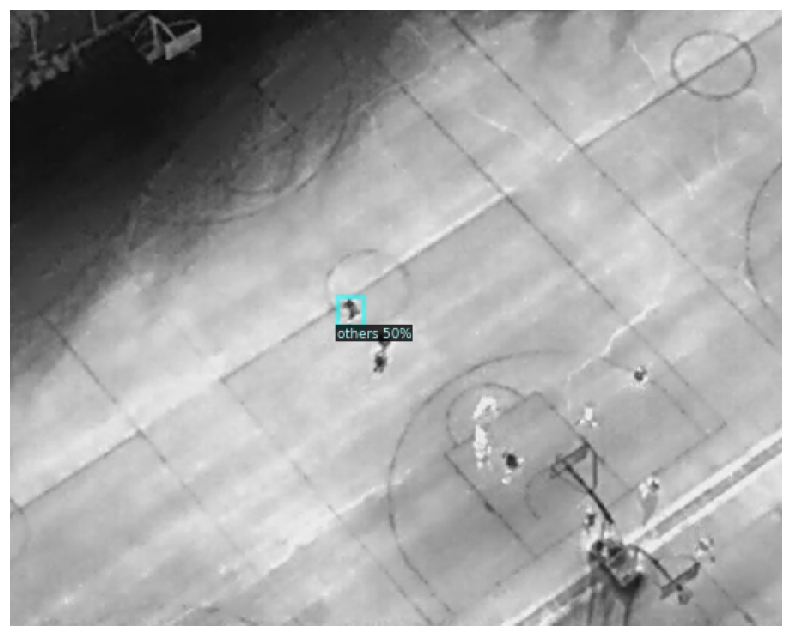

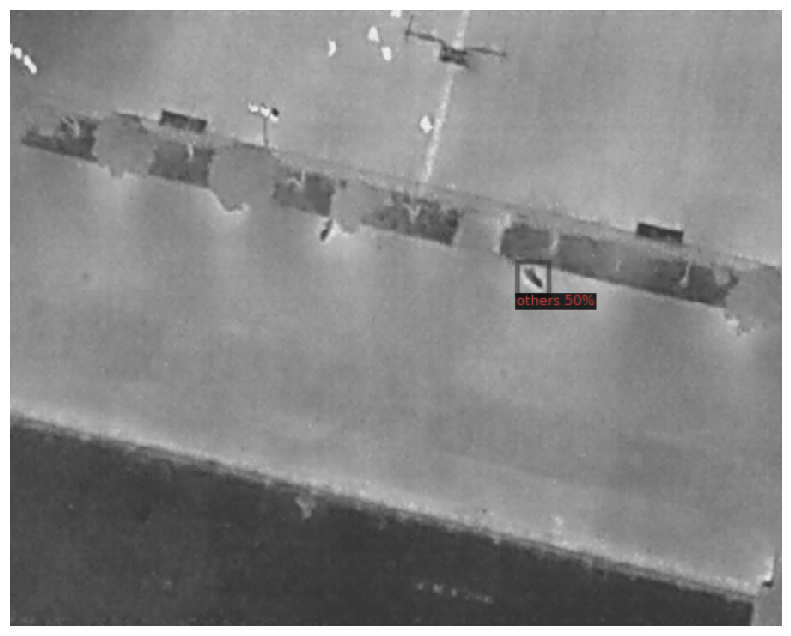

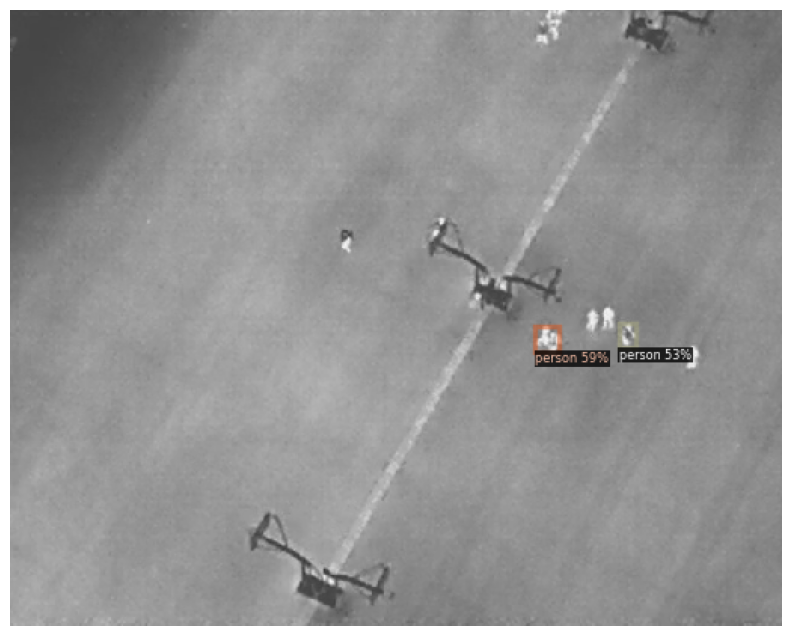

In [25]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

# Load the configuration and update it with trained model weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TEST = ("hit_val2",) # Set test dataset
cfg.MODEL.RETINANET.NUM_CLASSES = 3 # Your dataset has 3 classes
cfg.MODEL.WEIGHTS = os.path.join("/content/retinanet_output", "model_final.pth") # Path to the trained model weights
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5 # Set a threshold for predictions

# Initialize the predictor
predictor = DefaultPredictor(cfg)


# Pick a few random images from validation dataset
dataset_dicts = DatasetCatalog.get("hit_val2")
metadata = MetadataCatalog.get("hit_val2")

for d in random.sample(dataset_dicts, 3):  # visualize 3 random samples
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  # model prediction

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)  # convert BGR -> RGB
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

In [29]:
import os
import shutil
import zipfile
from detectron2.config import get_cfg

# --- Create a results directory ---
save_dir = "/content/retinanet_results"
os.makedirs(save_dir, exist_ok=True)

# Load the configuration
cfg = get_cfg()
# Assuming the config used for training is the one currently in memory
# You might want to load it from a saved file if you had one
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.RETINANET.NUM_CLASSES = 3 # Your dataset has 3 classes
cfg.OUTPUT_DIR = "/content/retinanet_output" # Ensure output directory is set
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Path to the trained model weights
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5 # Set a threshold for predictions


# Save the configuration to the output directory
config_save_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
with open(config_save_path, 'w') as f:
    f.write(cfg.dump())


# 1️⃣ Save trained model weights
shutil.copy(cfg.MODEL.WEIGHTS, os.path.join(save_dir, "model_final.pth"))

# 2️⃣ Save config file used
shutil.copy(config_save_path, os.path.join(save_dir, "config.yaml"))

# 3️⃣ Save evaluation metrics (if you already saved them as JSON/CSV, otherwise we’ll create one)
metrics_file = "/content/retinanet_output/metrics.json" # Assuming metrics were saved here
if os.path.exists(metrics_file):
    shutil.copy(metrics_file, os.path.join(save_dir, "metrics.json"))
else:
    # If metrics were not saved, you might need to re-run evaluation or skip this step
    print("Metrics file not found at:", metrics_file)


# 4️⃣ Save some visualization results
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor # Import DefaultPredictor

# Initialize the predictor
predictor = DefaultPredictor(cfg)

os.makedirs(f"{save_dir}/visuals", exist_ok=True)
dataset_dicts = DatasetCatalog.get("hit_val2")
metadata = MetadataCatalog.get("hit_val2")

for i, d in enumerate(random.sample(dataset_dicts, 5)):  # save 5 random samples
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    out_path = f"{save_dir}/visuals/pred_{i}.png"
    # Save as RGB, as matplotlib displays in RGB
    cv2.imwrite(out_path, cv2.cvtColor(out.get_image(), cv2.COLOR_RGB2BGR))


# --- ZIP everything ---
zip_path = "/content/retinanet_results.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(save_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, save_dir))

print(f"✅ All results zipped at: {zip_path}")

# --- Download to desktop ---
from google.colab import files
files.download(zip_path)

[09/20 15:28:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/retinanet_output/model_final.pth ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /content/retinanet_output/model_final.pth ...


[09/20 15:28:12 d2.data.datasets.coco]: Loaded 287 images in COCO format from /content/val.json
✅ All results zipped at: /content/retinanet_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import shutil
from google.colab import files

# List of folders to zip
folders = ['output', 'retinanet_output', 'retinanet_results']

for folder in folders:
    # Create a zip file for each folder
    shutil.make_archive(folder, 'zip', f'/content/{folder}')
    # Download the zip file
    files.download(f'{folder}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>